In [ ]:
#| default_exp highway

In [ ]:
#| include: false
from fastcore.all import *

In [ ]:
#| exporti
import numpy as np
from dataclasses import dataclass, field

import matplotlib.pyplot as plt


## Deep Reinforcement Learning

Let's create a very simple infinite lane model, with some distance before and behind ego-vehicle. It is populated by vehicles all driving at the same speed. We can step time forward, which moves all vehicles some distance. Sometimes vehicles appear at the beginning of the stretch of road, and vehicles also disappear, when they reach the end of the modeled stretch.

In [ ]:
#| export

@dataclass
class Lane:

    speed: float  # Speed of the vehicles
    arrival_rate: float  # Rate of vehicle arrivals (Poisson process)
    minimum_distance: float  # Minimum distance required between vehicles
    vehicles: list = field(default_factory=list)
    L : float = 1000  # Length of the road

    def step(self, dt):
        """Advance the simulation by one time step."""
        # Generate at most one new vehicle if it satisfies minimum distance
        if np.random.poisson(self.arrival_rate * dt) > 0:
            if not self.vehicles or (self.vehicles[-1] + self.L / 2>= self.minimum_distance):
                self.vehicles.append(-self.L / 2)
        
        # Update vehicle positions
        self.vehicles = [pos + self.speed * dt for pos in self.vehicles if pos + self.speed * dt <= self.L / 2]

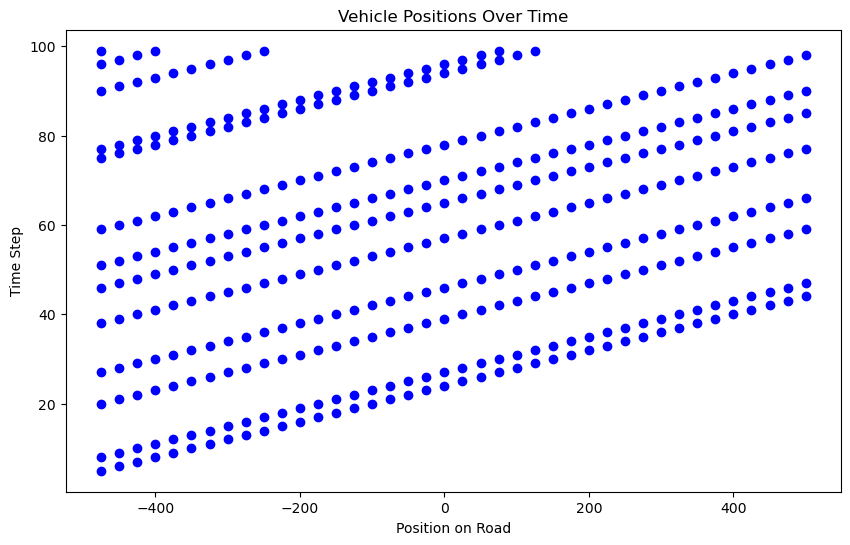

In [ ]:

def run_simulation(lane: Lane, duration: float, dt: float):
    """Run the simulation for a given duration with time step dt."""
    time = 0
    positions_over_time = []
    while time < duration:
        lane.step(dt)
        positions_over_time.append(list(lane.vehicles))
        time += dt
    return positions_over_time

lane = Lane(
    speed=25,
    arrival_rate=0.15,
    minimum_distance=32  # Minimum distance calculated
)

# Run simulation
simulation_duration = 100  # Total duration of the simulation
time_step = 1  # Time step for the simulation
positions_over_time = run_simulation(lane, simulation_duration, time_step)

# Visualization
plt.figure(figsize=(10, 6))
for t, positions in enumerate(positions_over_time):
    plt.plot(positions, [t] * len(positions), 'bo')
plt.xlabel('Position on Road')
plt.ylabel('Time Step')
plt.title('Vehicle Positions Over Time')
plt.show()

### Three-Lane Highway Setup

In this three-lane highway setup, we have designated different lanes for varying speeds to ensure smooth traffic flow and safety. The slow lane is intended for vehicles traveling at lower speeds, the middle lane for moderate speeds, and the fast lane for higher speeds. Each lane has an associated speed limit in miles per hour (mph), which has been converted to meters per second (m/s) for calculation purposes. The stopping distance is computed based on typical deceleration rates to ensure safe following distances between vehicles.

| Lane         | mph | Approx m/s | Approx Stopping Distance (meters) |
|--------------|-----|------------|------------------------------------|
| Slow Lane    | 55  | 25         | 32                                 |
| Middle Lane  | 65  | 29         | 43                                 |
| Fast Lane    | 75  | 34         | 59                                 |

In this setup, the slow lane is suitable for vehicles traveling at approximately 55 mph (25 m/s), requiring a stopping distance of around 32 meters. The middle lane accommodates vehicles traveling at around 65 mph (29 m/s), with a stopping distance of about 43 meters. The fast lane is designed for vehicles moving at higher speeds, approximately 75 mph (34 m/s), necessitating a stopping distance of around 59 meters. This structured arrangement promotes safer driving conditions and efficient traffic management by aligning vehicle speeds with appropriate stopping distances.

In [ ]:
#| export

class Highway:
    def __init__(self):
        self.slow_lane = Lane(speed=25, arrival_rate=0.15, minimum_distance=32)
        self.middle_lane = Lane(speed=29, arrival_rate=0.15, minimum_distance=43)
        self.fast_lane = Lane(speed=34, arrival_rate=0.15, minimum_distance=59)

    def step(self, dt):
        """Advance the simulation by one time step for all lanes."""
        self.slow_lane.step(dt)
        self.middle_lane.step(dt)
        self.fast_lane.step(dt)

In [10]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image
from IPython.display import HTML

In [ ]:

# Create Highway instance
highway = Highway()

# Run simulation and create GIF
duration = 100  # Total duration of the simulation
dt = 1  # Time step for the simulation

fig, ax = plt.subplots(figsize=(12, 3))
frames = int(duration / dt)

def update(frame):
    highway.step(dt)
    ax.clear()
    ax.set_xlim(-Lane.L / 2, Lane.L / 2)
    ax.set_ylim(-1, 3)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Slow Lane', 'Middle Lane', 'Fast Lane'])
    ax.plot(highway.slow_lane.vehicles, [0] * len(highway.slow_lane.vehicles), 'bo', label='Slow Lane')
    ax.plot(highway.middle_lane.vehicles, [1] * len(highway.middle_lane.vehicles), 'go', label='Middle Lane')
    ax.plot(highway.fast_lane.vehicles, [2] * len(highway.fast_lane.vehicles), 'ro', label='Fast Lane')

anim = FuncAnimation(fig, update, frames=frames, repeat=False);

In [ ]:

# Uncomment to save and check:
# anim.save("highway.gif", writer=PillowWriter(fps=10))
# plt.close(fig)  # Close the figure to prevent display in the notebook
# Image(filename="highway.gif") # Display the saved GIF in the notebook

In [ ]:
# Show the animation in the notebook:
HTML(anim.to_jshtml())